Dataset loaded with 60000 images across 100 classes and 20 superclasses.

Plotting Class Distribution (100 Classes):


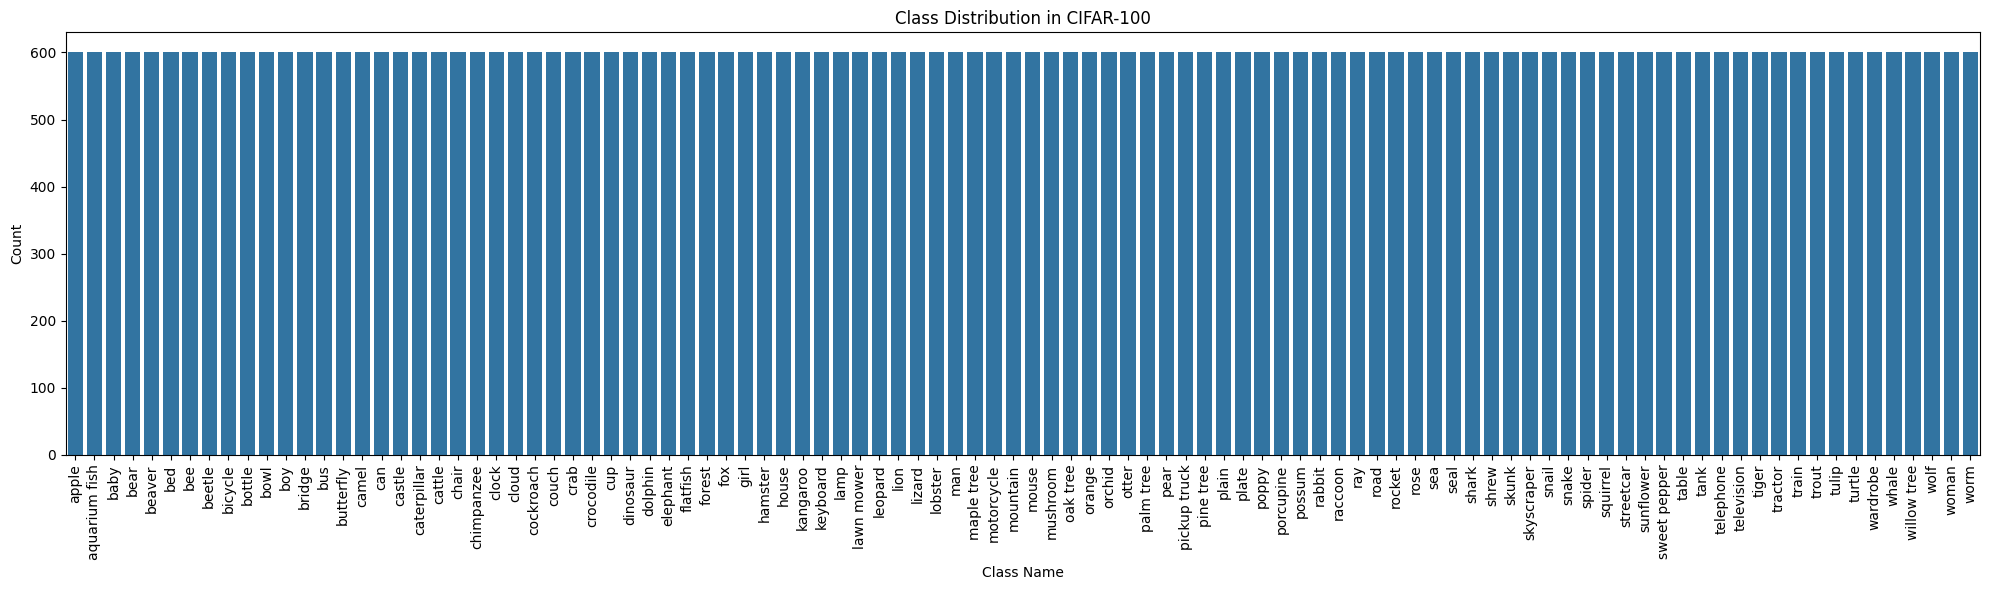


Plotting Superclass Distribution (20 Superclasses):


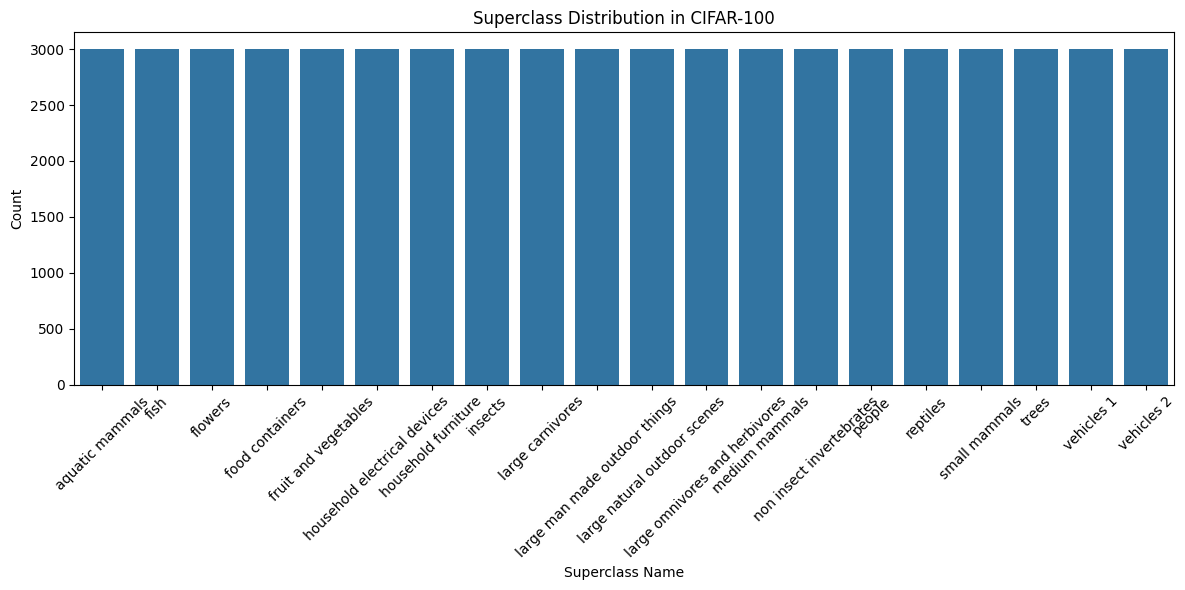


Labeled Data: 4800 samples
Unlabeled Data: 43200 samples
Validation Data: 12000 samples
Test Data: 12000 samples

Displaying Random Images from Dataset:


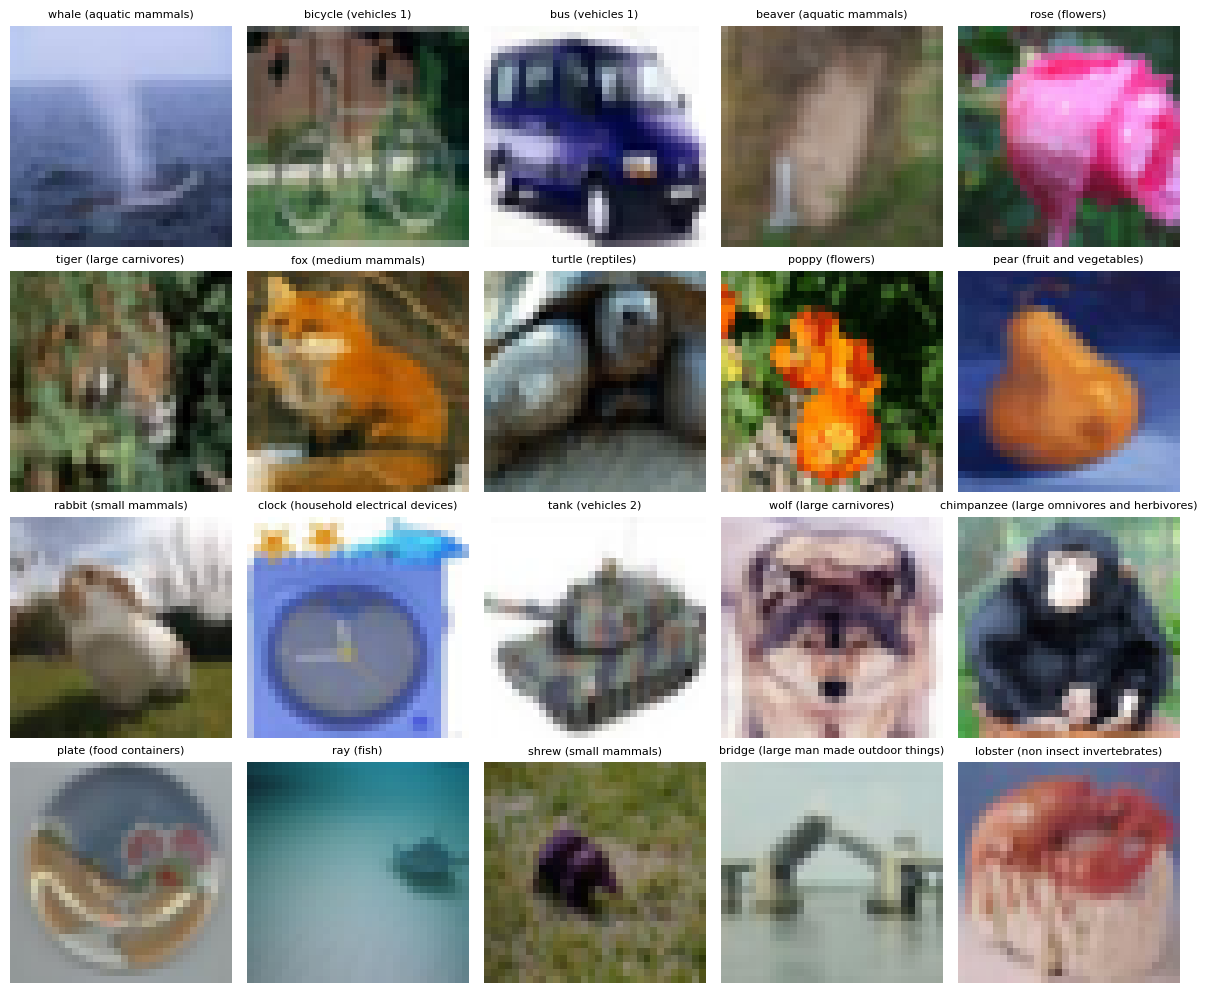


Weak Augmentation: Random Crop with Horizontal Flip
Medium Augmentation: Color Jitter (brightness, contrast, saturation, hue) and Rotation
Strong Augmentation: Perspective Transformation, Affine Transformation with Shear and Cutout


Displaying Augmented Images:


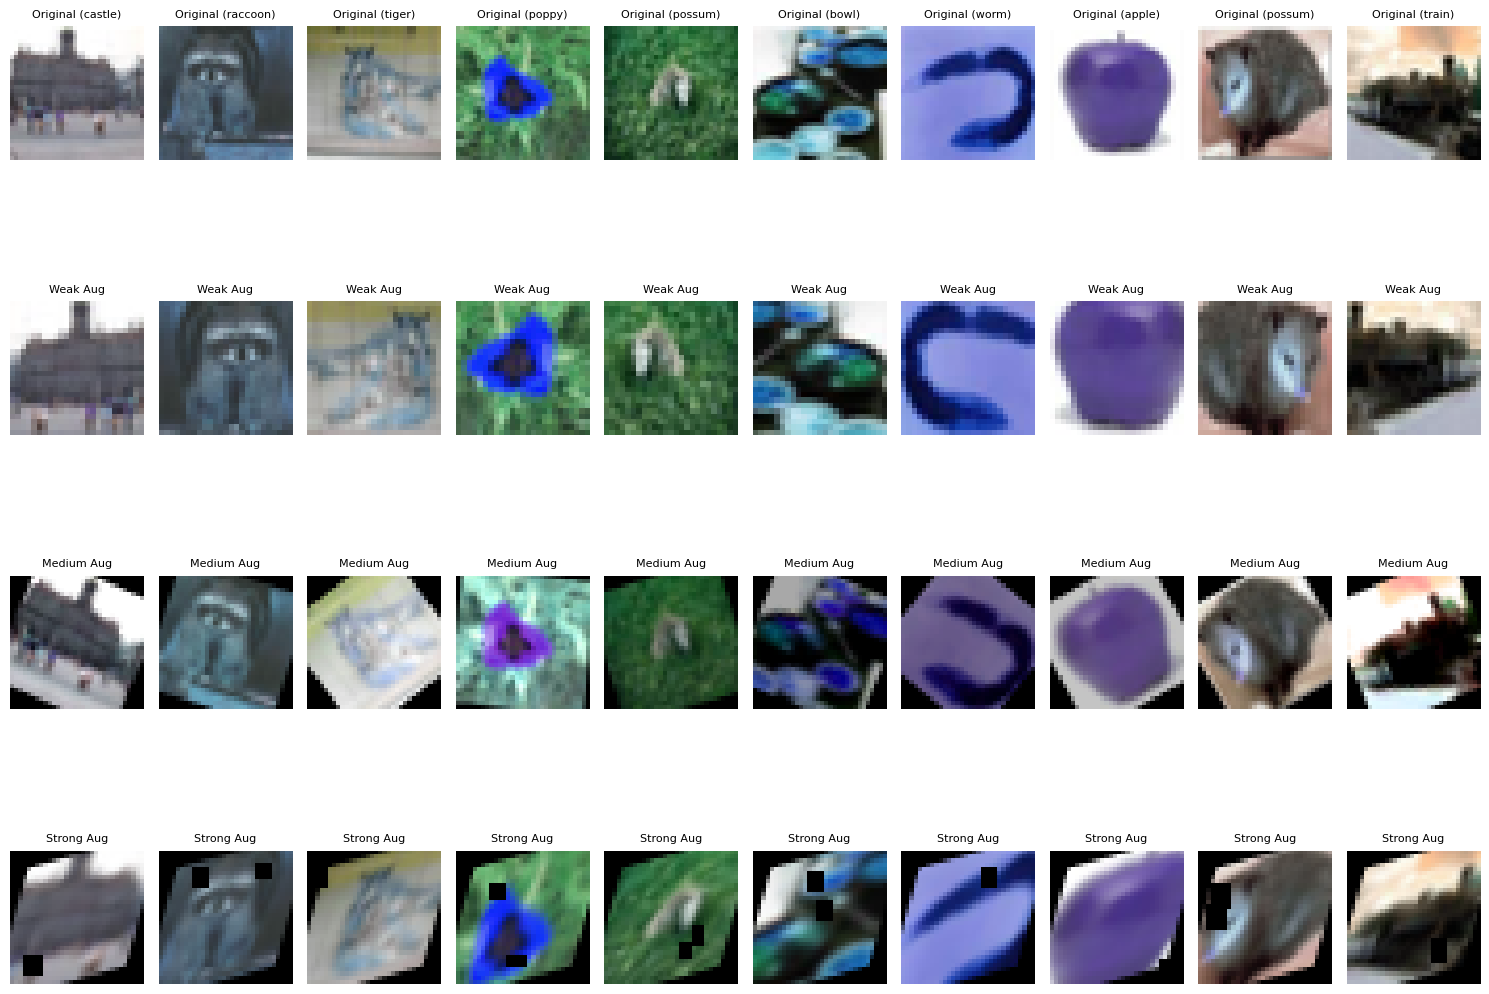

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
import albumentations as ALB
import cv2

RANDOM_STATE = 2022484
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

def load_cifar100(dataset_path):
    data = []
    labels = []
    class_to_idx = {}
    idx_to_class = {}
    superclass_to_class = {}
    idx_to_superclass = {}
    
    for superclass_idx, (superclass, class_dirs) in enumerate([(folder, os.listdir(os.path.join(dataset_path, folder))) for folder in os.listdir(dataset_path)]):
        superclass_to_class[superclass] = []
        idx_to_superclass[superclass_idx] = superclass
        for class_name in class_dirs:
            class_path = os.path.join(dataset_path, superclass, class_name)
            if os.path.isdir(class_path):
                class_to_idx[class_name] = len(class_to_idx)
                idx_to_class[class_to_idx[class_name]] = class_name
                superclass_to_class[superclass].append(class_to_idx[class_name])
                
                for img_path in glob(os.path.join(class_path, "*.png")):
                    image = Image.open(img_path).convert("RGB")
                    data.append((np.array(image), class_to_idx[class_name], superclass_idx))

    print(f"Dataset loaded with {len(data)} images across {len(class_to_idx)} classes and {len(superclass_to_class)} superclasses.")
    return data, class_to_idx, idx_to_class, superclass_to_class, idx_to_superclass

dataset_path = r"X:\Projects\ML\Project\cifar_100"
data, class_to_idx, idx_to_class, superclass_to_class, idx_to_superclass = load_cifar100(dataset_path)

def plot_class_distribution(data, idx_to_class):
    class_counts = {}
    for _, label, _ in data:
        class_counts[idx_to_class[label]] = class_counts.get(idx_to_class[label], 0) + 1

    sorted_classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in sorted_classes]

    plt.figure(figsize=(20, 6))
    sns.barplot(x=sorted_classes, y=counts)
    plt.title("Class Distribution in CIFAR-100")
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

print("\nPlotting Class Distribution (100 Classes):")
plot_class_distribution(data, idx_to_class)

def plot_superclass_distribution(data, idx_to_superclass):
    superclass_counts = {}
    for _, _, superclass in data:
        superclass_name = idx_to_superclass[superclass]
        superclass_counts[superclass_name] = superclass_counts.get(superclass_name, 0) + 1

    sorted_superclasses = sorted(superclass_counts.keys())
    counts = [superclass_counts[scls] for scls in sorted_superclasses]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=sorted_superclasses, y=counts)
    plt.title("Superclass Distribution in CIFAR-100")
    plt.xlabel("Superclass Name")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nPlotting Superclass Distribution (20 Superclasses):")
plot_superclass_distribution(data, idx_to_superclass)

def train_val_test(data, labeled_ratio=0.1, validation_ratio=0.2):
    images, labels, superclasses = zip(*data)
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=validation_ratio, stratify=labels, random_state=RANDOM_STATE)
    labeled_images, unlabeled_images, labeled_labels, _ = train_test_split(train_images, train_labels, test_size=1 - labeled_ratio, stratify=train_labels, random_state=RANDOM_STATE)

    print(f"\nLabeled Data: {len(labeled_images)} samples")
    print(f"Unlabeled Data: {len(unlabeled_images)} samples")
    print(f"Validation Data: {len(val_images)} samples")
    print(f"Test Data: {len(images) - len(train_images)} samples")

    return labeled_images, unlabeled_images, val_images, labeled_labels, val_labels

labeled_images, unlabeled_images, val_images, labeled_labels, val_labels = train_val_test(data)

def display_random_images(data, num_images=20):
    random_indices = random.sample(range(len(data)), num_images)
    selected_images = [data[i] for i in random_indices]

    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    for ax, (image, label, superclass) in zip(axes.flat, selected_images):
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"{idx_to_class[label]} ({idx_to_superclass[superclass]})", fontsize=8)
    plt.tight_layout()
    plt.show()
print("\nDisplaying Random Images from Dataset:")
display_random_images(data)

def display_augmented_images(data, num_images=10):
    weak_transform = ALB.Compose([ALB.RandomCrop(height=25, width=25, p=1), ALB.HorizontalFlip(p=1)])
    medium_transform = ALB.Compose([ALB.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=1), ALB.Rotate(limit=40, p=1)])
    strong_transform = ALB.Compose([ALB.Perspective(scale=(0.05, 0.1), p=1), ALB.Affine(shear=15, p=1), ALB.CoarseDropout(p=1)])

    random_indices = random.sample(range(len(data)), num_images)
    selected_images = [data[i] for i in random_indices]

    fig, axes = plt.subplots(4, num_images, figsize=(15, 12))

    for i, (image, label, _) in enumerate(selected_images):
        original_image = np.array(Image.fromarray(image))

        weak_image = weak_transform(image=original_image)['image']
        medium_image = medium_transform(image=original_image)['image']
        strong_image = strong_transform(image=original_image)['image']

        axes[0, i].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Original ({idx_to_class[label]})", fontsize=8)

        axes[1, i].imshow(cv2.cvtColor(weak_image, cv2.COLOR_BGR2RGB))
        axes[1, i].axis("off")
        axes[1, i].set_title("Weak Aug", fontsize=8)

        axes[2, i].imshow(cv2.cvtColor(medium_image, cv2.COLOR_BGR2RGB))
        axes[2, i].axis("off")
        axes[2, i].set_title("Medium Aug", fontsize=8)

        axes[3, i].imshow(cv2.cvtColor(strong_image, cv2.COLOR_BGR2RGB))
        axes[3, i].axis("off")
        axes[3, i].set_title("Strong Aug", fontsize=8)

    plt.tight_layout()
    plt.show()
    
print("\nWeak Augmentation: Random Crop with Horizontal Flip")
print("Medium Augmentation: Color Jitter (brightness, contrast, saturation, hue) and Rotation")
print("Strong Augmentation: Perspective Transformation, Affine Transformation with Shear and Cutout\n")   
print("\nDisplaying Augmented Images:")
display_augmented_images(data)
